# Peak N

In [22]:
# imports
from importlib import reload

import os
import glob
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from ocpy.utils import plotting

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle
from cugn import defs
from cugn import highres

# Load CUGN

In [2]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]
grid_tbl = items[3]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


In [3]:
lat = np.nanmedian(ds.lat.data)
lon = np.nanmedian(ds.lon.data)

In [7]:
salinity = ds_high.salinity.values
temperature = ds_high.temperature.values

# Calculate

In [48]:
mname = '20503001'
in_grid = (grid_extrem.mission.values == mname)
np.unique(grid_extrem.mission_profile.values[in_grid])
#mprofile = 14  # If z=10m means average 5-15m

array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40, 122,
       123, 267, 272, 623, 624, 625, 628, 629, 651, 670, 672, 673, 674,
       675, 676, 836, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847,
       848, 851, 852, 853, 854, 862, 863, 936, 937, 938, 939, 940, 941,
       942, 943, 944, 950, 951, 952, 955, 957, 958, 961, 962, 964, 965,
       966, 967, 972, 973, 974, 975, 976, 977, 981, 982, 983, 988, 989,
       991], dtype=int32)

## Find the obs

In [85]:
#mission_profile = 673
mission_profile = 982
# Find the obs
min_depth = 2.
my_obs = ds_high.profile_obs_index.values == mission_profile
my_obs &= ds_high.depth.values > min_depth

# Calculate density, etc.

# Require finite
my_obs &= np.isfinite(salinity) & np.isfinite(temperature)

In [86]:
reload(highres)
MLD, Ns, z_Npeak, extras = highres.calc_mld_N(ds_high.depth.values[my_obs],
                             salinity[my_obs], temperature[my_obs],
                             lat, lon, 100., return_extras=True)
MLD, z_Npeak

(array(5.35475103), np.float64(5.7193))

## Profile

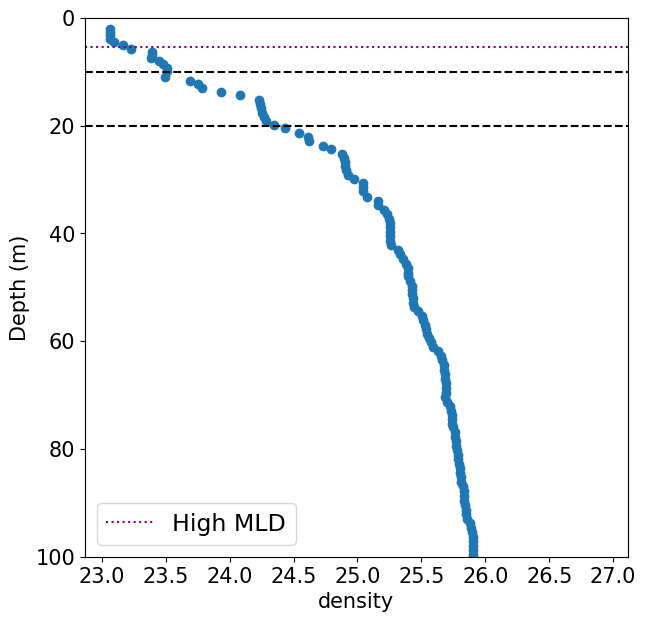

In [87]:
#q = 'salinity'
#q = 'temperature'
q = 'density'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
if q == 'density':
    ax.plot(extras['sigma0'], extras['z_sort'], 'o')
else:
    ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
# Add grid values
if q not in ['density']:
    for layer in [0,1]:
        ax.plot(ds[q].data[layer, gprofile], ds.depth[layer], 'r*')
    
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High MLD')
#ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

# Find the first N peak

In [73]:
dN = extras['N'] - np.roll(extras['N'],-1)
dN2 = extras['N'] - np.roll(extras['N'],-2)
dN[0:10]

array([  0.        ,  -1.24361817,  -8.39434338,  -7.69802691,
        -1.6270787 ,  -6.10099235,   3.46537909,  21.59868043,
       -12.21830721,  -3.39775499])

In [74]:
dN2[0:10]

array([ -1.24361817,  -9.63796155, -16.09237029,  -9.32510561,
        -7.72807106,  -2.63561327,  25.06405952,   9.38037322,
       -15.61606221,  -0.82930039])

In [75]:
extras['N'][0:10]

array([ 0.        ,  0.        ,  1.24361817,  9.63796155, 17.33598846,
       18.96306716, 25.06405952, 21.59868043,  0.        , 12.21830721])

In [78]:
peaks = np.where((dN > 0) & (dN2 > 0) & (extras['N'] > 0))[0] 
peaks[0:10]

array([ 6,  7, 10, 11, 15, 18, 19, 20, 27, 28])

In [79]:
first_peak = peaks[0]
z_Npeak = extras['z_sort'][first_peak]
z_Npeak

np.float64(5.7193)

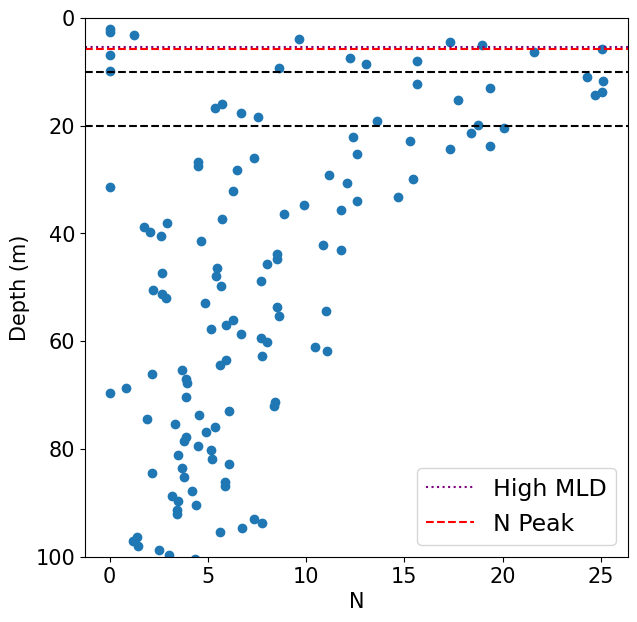

In [88]:
q = 'N'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
if q == 'density':
    ax.plot(extras['sigma0'], extras['z_sort'], 'o')
elif q == 'N':
    ax.plot(extras['N'], extras['z_sort'], 'o')
else:
    ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
# Add grid values
if q not in ['density', 'N']:
    for layer in [0,1]:
        ax.plot(ds[q].data[layer, gprofile], ds.depth[layer], 'r*')
    
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High MLD')
ax.axhline(z_Npeak, color='red', ls='--', label='N Peak')
#ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

# Compare for the full mission

In [90]:
full_file = '/home/xavier/Projects/Oceanography/data/Spray/CUGN/full_grid_line90.parquet'
df = pandas.read_parquet(full_file)

In [96]:
in_mission = df.mission == mname
df_in = df[in_mission].copy()

# Compare

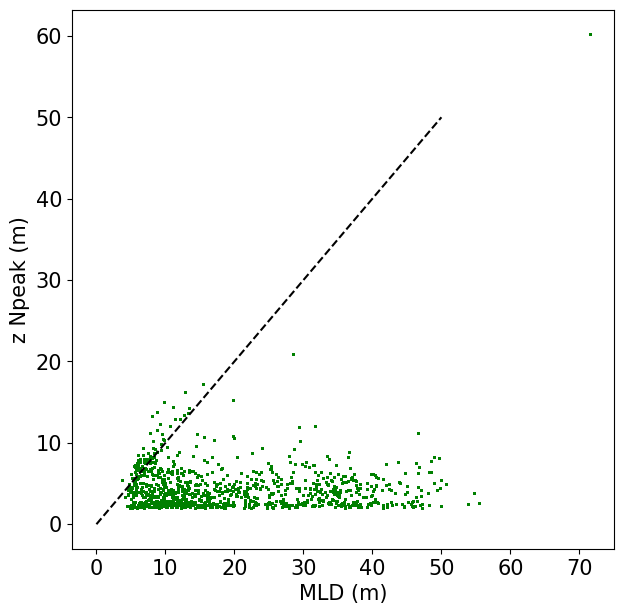

In [106]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.scatter(df_in.MLD, df_in.zNpeak, s=1., color='g')
ax.plot([0., 50.], [0.,50], 'k--')
#
ax.set_xlabel('MLD (m)')
ax.set_ylabel('z Npeak (m)')
#
#ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
#
#ax.legend(fontsize=17.)
#
plt.show()

## Query

In [100]:
goofy = (df_in.MLD > 30.) & (df_in.zNpeak < 7.)
np.where(goofy)[0]

array([   69,    70,    71, ..., 46834, 46838, 46865])

In [101]:
df_in.iloc[69]

depth                       0
profile                 44086
row                        31
col                        23
doxy               269.422301
mission              20503001
mission_profile            71
MLD                 30.471684
N                    1.452805
zNpeak                 2.7406
doxy_p              96.595745
Name: 9850, dtype: object

In [102]:
mname

'20503001'

## Investigate

In [125]:
def calcit(mission_profile):
    # Find the obs
    my_obs = ds_high.profile_obs_index.values == mission_profile
    my_obs &= ds_high.depth.values > min_depth
    my_obs &= np.isfinite(salinity) & np.isfinite(temperature)
    
    # Do it
    reload(highres)
    MLD, Ns, z_Npeak, extras = highres.calc_mld_N(ds_high.depth.values[my_obs],
                                 salinity[my_obs], temperature[my_obs],
                                 lat, lon, 100., return_extras=True, Npeak_min=10.)
    #
    return MLD, Ns, z_Npeak, extras

In [108]:
mission_profile = 71
# Find the obs
my_obs = ds_high.profile_obs_index.values == mission_profile
my_obs &= ds_high.depth.values > min_depth
my_obs &= np.isfinite(salinity) & np.isfinite(temperature)

# Do it
reload(highres)
MLD, Ns, z_Npeak, extras = highres.calc_mld_N(ds_high.depth.values[my_obs],
                             salinity[my_obs], temperature[my_obs],
                             lat, lon, 100., return_extras=True, Npeak_min=10.)

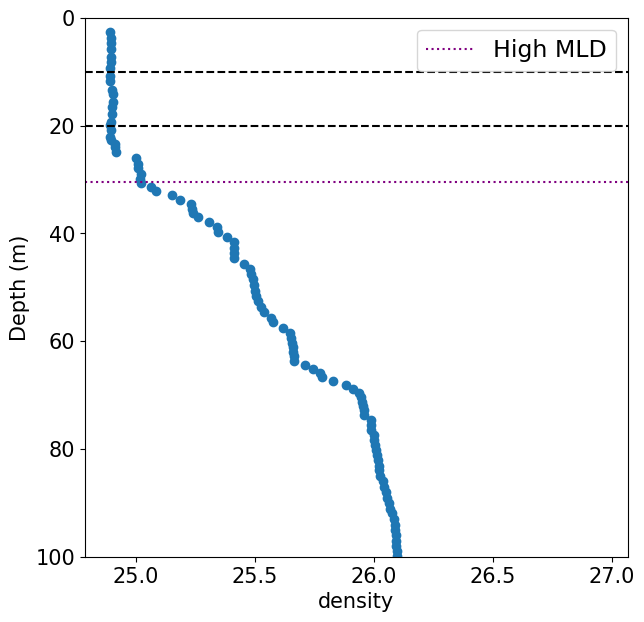

In [109]:
q = 'density'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
if q == 'density':
    ax.plot(extras['sigma0'], extras['z_sort'], 'o')
else:
    ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
# Add grid values
if q not in ['density']:
    for layer in [0,1]:
        ax.plot(ds[q].data[layer, gprofile], ds.depth[layer], 'r*')
    
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High MLD')
#ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

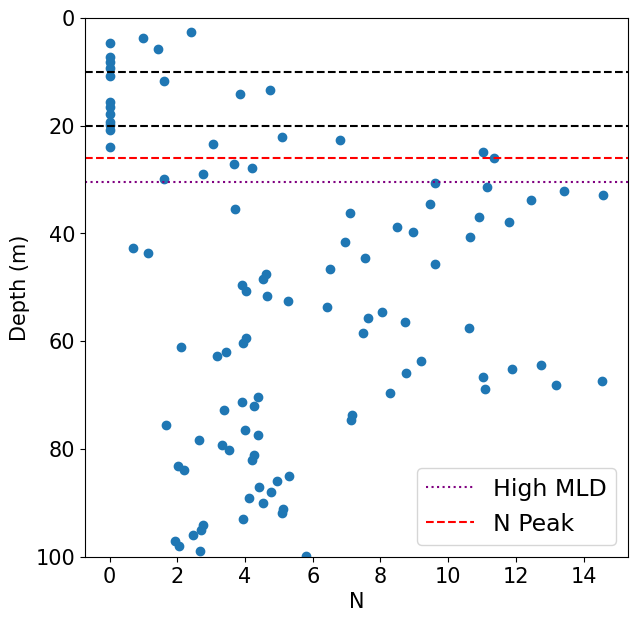

In [110]:
q = 'N'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
if q == 'density':
    ax.plot(extras['sigma0'], extras['z_sort'], 'o')
elif q == 'N':
    ax.plot(extras['N'], extras['z_sort'], 'o')
else:
    ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
# Add grid values
if q not in ['density', 'N']:
    for layer in [0,1]:
        ax.plot(ds[q].data[layer, gprofile], ds.depth[layer], 'r*')
    
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High MLD')
ax.axhline(z_Npeak, color='red', ls='--', label='N Peak')
#ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

# Redo them all

In [114]:
in_grid = (grid_tbl.mission.values == mname)
mprofiles = np.unique(grid_tbl.mission_profile.values[in_grid])
reload(highres)
MLDs, Ns, zNs = highres.calc_mission(
            gfiles[0], mprofiles, max_depth=100.)

/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/xavier/miniconda3/envs/ocean/lib/python3.12/site-packa

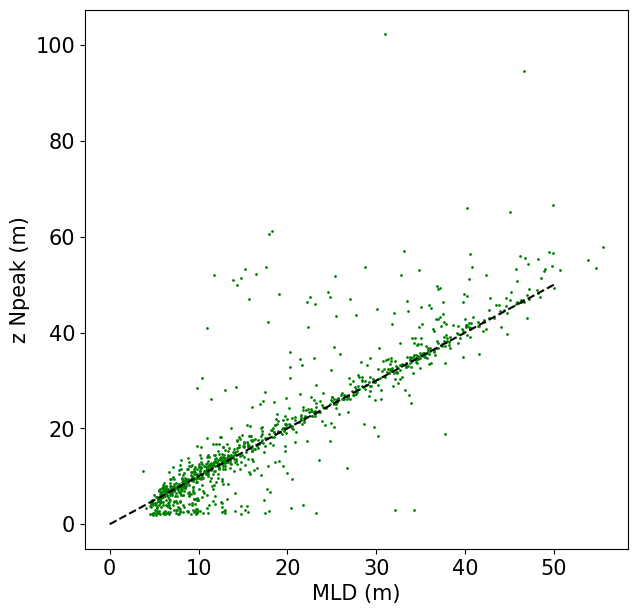

In [115]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.scatter(MLDs, zNs, s=1., color='g')
ax.plot([0., 50.], [0.,50], 'k--')
#
ax.set_xlabel('MLD (m)')
ax.set_ylabel('z Npeak (m)')
#
#ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
#
#ax.legend(fontsize=17.)
#
plt.show()

## Low N

In [117]:
low_N = (MLDs > 30) & (zNs < 10.)
mprofiles[np.where(low_N)[0]]

array([527, 795], dtype=int32)

In [119]:
mission_profile = 527
# Find the obs
my_obs = ds_high.profile_obs_index.values == mission_profile
my_obs &= ds_high.depth.values > min_depth
my_obs &= np.isfinite(salinity) & np.isfinite(temperature)

# Do it
reload(highres)
MLD, Ns, z_Npeak, extras = highres.calc_mld_N(ds_high.depth.values[my_obs],
                             salinity[my_obs], temperature[my_obs],
                             lat, lon, 100., return_extras=True, Npeak_min=10.)

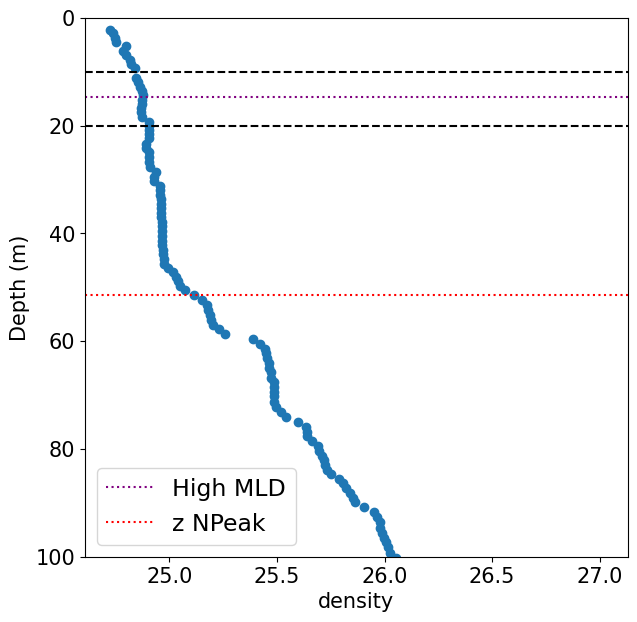

In [129]:
q = 'density'
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
if q == 'density':
    ax.plot(extras['sigma0'], extras['z_sort'], 'o')
else:
    ax.plot(ds_high[q].values[my_obs], ds_high.depth[my_obs], 'o')
#
ax.set_xlabel(q)
ax.set_ylabel('Depth (m)')
#
ax.set_ylim(100, 0.)
#ax.set_xlim(33.4, 34.)
plotting.set_fontsize(ax, 15.)
#
for depth in [10, 20.]:
    ax.axhline(depth, color='k', ls='--')
# MLD
ax.axhline(MLD, color='purple', ls=':', label='High MLD')
ax.axhline(z_Npeak, color='red', ls=':', label='z NPeak')
#ax.axhline(gMLD+5, color='g', ls=':', label='Grid')
#
ax.legend(fontsize=17.)
#
plt.show()

In [123]:
hi_zN = (MLDs < 15) & (zNs > 50.)
mprofiles[np.where(hi_zN)]

array([116, 352, 388], dtype=int32)

In [126]:
MLD, Ns, z_Npeak, extras = calcit(116)